In [2]:
spark

In [3]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

import pyspark
from delta import *
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt

In [33]:
df1 = spark.read.csv("/MIMIC2/yearOffset.csv", header=True)
df1.write.format("delta").mode("overwrite").option("overwriteSchema",True).save("/delta_MIMIC2/yearOffset")

[('subject_id', 'string'), ('yearOffset', 'string')]

In [38]:
df = spark.sql("""
select subject_id, cast(yearOffset as integer) from delta.`/delta_MIMIC2/yearOffset` yearOffset
""")
df.write.format("delta").mode("overwrite").option("overwriteSchema",True).save("/delta_MIMIC2/yearOffset")

root
 |-- subject_id: string (nullable = true)
 |-- yearOffset: integer (nullable = true)



In [31]:
df1 = spark.read.csv("/MIMIC2/admissions.csv", header=True)
df1.write.format("delta").mode("overwrite").option("overwriteSchema",True).save("/delta_MIMIC2/admissions")

In [40]:
#admissions
df = spark.sql("""
select hadm_id,admissions.subject_id, 
cast(concat(cast((year(CAST(UNIX_TIMESTAMP(admit_dt, 'd/M/yyyy HH:mm:ss') AS TIMESTAMP)) - yearOffset) as string),SUBSTR(cast(CAST(UNIX_TIMESTAMP(admit_dt, 'd/M/yyyy HH:mm:ss') AS TIMESTAMP) as string),5)) AS TIMESTAMP) as admit_dt,
cast(concat(cast((year(CAST(UNIX_TIMESTAMP(disch_dt, 'd/M/yyyy HH:mm:ss') AS TIMESTAMP)) - yearOffset) as string),SUBSTR(cast(CAST(UNIX_TIMESTAMP(disch_dt, 'd/M/yyyy HH:mm:ss') AS TIMESTAMP) as string),5)) AS TIMESTAMP) as disch_dt
from delta.`/delta_MIMIC2/admissions` admissions
join delta.`/delta_MIMIC2/yearOffset` yearOffset
on admissions.subject_id = yearOffset.subject_id
""")
df.printSchema()

root
 |-- hadm_id: string (nullable = true)
 |-- subject_id: string (nullable = true)
 |-- admit_dt: timestamp (nullable = true)
 |-- disch_dt: timestamp (nullable = true)



In [41]:
df.write.format("delta").mode("overwrite").option("overwriteSchema",True).save("/delta_MIMIC2/admissions")

In [44]:
#d_patients
df = spark.sql("""
select d_patients.subject_id,sex,
cast(concat(cast((year(CAST(UNIX_TIMESTAMP(dob, 'd/M/yyyy HH:mm:ss') AS TIMESTAMP)) - yearOffset) as string),SUBSTR(cast(CAST(UNIX_TIMESTAMP(dob, 'd/M/yyyy HH:mm:ss') AS TIMESTAMP) as string),5)) AS TIMESTAMP) as dob,
cast(concat(cast((year(CAST(UNIX_TIMESTAMP(dod, 'd/M/yyyy HH:mm:ss') AS TIMESTAMP)) - yearOffset) as string),SUBSTR(cast(CAST(UNIX_TIMESTAMP(dod, 'd/M/yyyy HH:mm:ss') AS TIMESTAMP) as string),5)) AS TIMESTAMP) as dod,
hospital_expire_flg 
from delta.`/delta_MIMIC2/d_patients` d_patients
join delta.`/delta_MIMIC2/yearOffset` yearOffset
on d_patients.subject_id = yearOffset.subject_id
""")
df.printSchema()

root
 |-- subject_id: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- dob: timestamp (nullable = true)
 |-- dod: timestamp (nullable = true)
 |-- hospital_expire_flg: string (nullable = true)



In [45]:
df.write.format("delta").mode("overwrite").option("overwriteSchema",True).save("/delta_MIMIC2/d_patients")

In [46]:
#Thong ke benh nhan theo lua tuoi
df = spark.sql("""
select period, count(*) num from
(select 
case 
    WHEN age < 2 THEN 'Infancy' 
    WHEN age >= 2 and age < 6 THEN 'Early Childhood' 
    WHEN age >= 6 and age < 12 THEN 'Later Childhood'
    WHEN age >= 12 and age < 20 THEN 'Adolescence'
    WHEN age >= 20 and age < 40 THEN 'Young adult'
    WHEN age >= 40 and age < 60 THEN 'Middle-aged'
    ELSE 'Senior Citizen' 
END as period from
(select extract(day from dod - dob)/365 as age from delta.`/delta_MIMIC2/d_patients`) age) period
group by period
order by num desc
""").toPandas()
df

,period,num
0,Senior Citizen,3151
1,Middle-aged,652
2,Young adult,110
3,Infancy,28
4,Adolescence,11


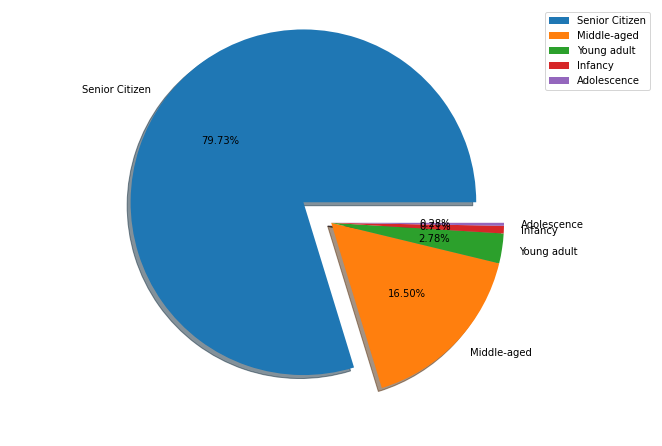

In [47]:
x = df['period'].values.tolist()
y = df['num'].values.tolist()
x,y
myexplode = [0.2, 0, 0, 0, 0]
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.axis('equal')
ax.pie(y, labels = x,autopct='%1.2f%%',explode = myexplode, shadow = True)
plt.legend()
plt.show()

In [4]:
#So ca nhap vien va so ca tu vong theo thoi gian (2005 to 2015)
dfadmissions = spark.sql("""
select year(admit_dt) year, count(*) num from delta.`/delta_MIMIC2/admissions` as admissions
where year(admit_dt) >= 2005 and year(admit_dt) <= 2015
group by year(admit_dt)
order by year(admit_dt)
""").toPandas()

dfdied = spark.sql("""
select year(dod) year, count(*) num from delta.`/delta_MIMIC2/d_patients` as d_patients
where year(dod) >= 2005 and year(dod) <= 2015 and hospital_expire_flg = 'Y'
group by year(dod)
order by year(dod)
""").toPandas()

In [5]:
res = spark.sql("""
select year(admit_dt) year, count(*) num from delta.`/delta_MIMIC2/admissions` as admissions
where year(admit_dt) >= 2005 and year(admit_dt) <= 2015
group by year(admit_dt)
order by year(admit_dt)
""").toPandas()

dfdied = spark.sql("""
select year(dod) year, count(*) num from delta.`/delta_MIMIC2/d_patients` as d_patients
where year(dod) >= 2005 and year(dod) <= 2015 and hospital_expire_flg = 'Y'
group by year(dod)
order by year(dod)
""").toPandas()

,year,num
0,2005,445
1,2006,438
2,2007,437
3,2008,466
4,2009,461
5,2010,452
6,2011,471
7,2012,495
8,2013,463
9,2014,469


In [6]:
res['numDied'] = dfdied['num']

In [7]:
res

,year,num,numDied
0,2005,445,146
1,2006,438,140
2,2007,437,131
3,2008,466,156
4,2009,461,158
5,2010,452,139
6,2011,471,145
7,2012,495,173
8,2013,463,162
9,2014,469,150


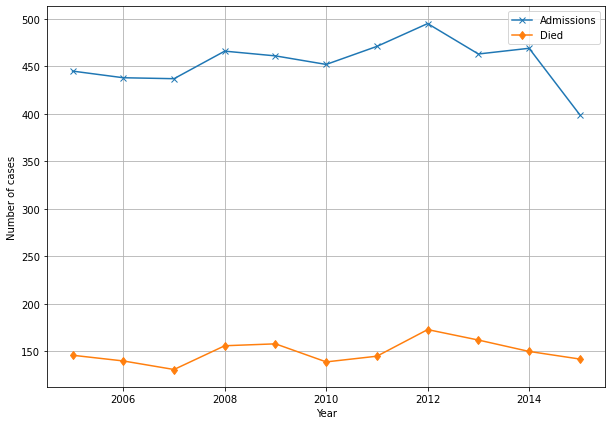

In [49]:
Year = dfadmissions['year'].values.tolist()
admissions = dfadmissions['num'].values.tolist()
died = dfdied['num'].values.tolist()
plt.figure(figsize=(10, 7))
plt.plot(Year, admissions, label = 'Admissions', marker = 'x')
plt.plot(Year, died, label = 'Died', marker = 'd')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.grid(True)
plt.show()

In [50]:
# 1. So luong benh nhan phan theo gioi tinh
df = spark.sql("""
select sex, count(*) as numCases from delta.`/delta_MIMIC2/d_patients` as d_patients
group by sex
order by numCases
""")
df

sex,numCases
null,13
F,1843
M,2096


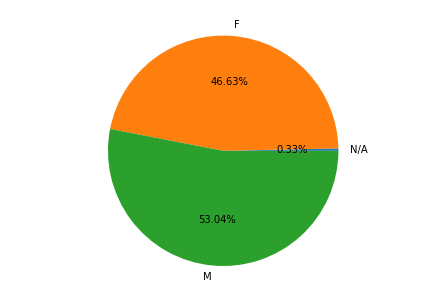

In [51]:
df = df.toPandas()

x = df['sex'].values.tolist()
x[0] = 'N/A'
y = df['numCases'].values.tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(y, labels = x,autopct='%1.2f%%')
plt.show()

In [54]:
#Cac benh pho bien theo thang cu the
month = input()
df = spark.sql("""
select * from
(select drgevents.itemid, description, month(admit_dt) as month, count(*) as num 
from delta.`/delta_MIMIC2/drgevents` as drgevents
join delta.`/delta_MIMIC2/d_codeditems` as d_codeditems
join delta.`/delta_MIMIC2/admissions` as admissions
on drgevents.itemid = d_codeditems.itemid and admissions.hadm_id = drgevents.hadm_id
group by drgevents.itemid, description, month
order by num desc) tmp
where month = """ + month)
df

4


itemid,description,month,num
60691,RESPIRATORY SYSTE...,4,31
60614,SEPTICEMIA AGE >1...,4,30
60206,HEART FAILURE & S...,4,15
60181,MAJOR CARDIOVASCU...,4,13
60272,G.I. HEMORRHAGE W...,4,12
60128,RESPIRATORY INFEC...,4,10
60024,INTRACRANIAL HEMO...,4,10
60490,RENAL FAILURE ...,4,9
60457,DIABETES AGE >35 ...,4,8
60681,EXTENSIVE O.R. PR...,4,8


In [59]:
#5 benh pho bien theo tung thang
df = spark.sql("""
select * from 
(select ROW_NUMBER() OVER(PARTITION BY month ORDER BY num desc) 
    AS ROW_NUMBER, * from
(select drgevents.itemid, description, month(admit_dt) as month, count(*) as num 
from delta.`/delta_MIMIC2/drgevents` as drgevents
join delta.`/delta_MIMIC2/d_codeditems` as d_codeditems
join delta.`/delta_MIMIC2/admissions` as admissions
on drgevents.itemid = d_codeditems.itemid and admissions.hadm_id = drgevents.hadm_id
group by drgevents.itemid, description, month
order by num desc) tmp) tmp1
where ROW_NUMBER < 6""")
df

ROW_NUMBER,itemid,description,month,num
1,60272,G.I. HEMORRHAGE W...,1,17
2,60614,SEPTICEMIA AGE >1...,1,17
3,60024,INTRACRANIAL HEMO...,1,16
4,60691,RESPIRATORY SYSTE...,1,15
5,60196,CIRCULATORY DISOR...,1,13
1,60691,RESPIRATORY SYSTE...,2,22
2,60614,SEPTICEMIA AGE >1...,2,20
3,60181,MAJOR CARDIOVASCU...,2,15
4,60272,G.I. HEMORRHAGE W...,2,12
5,60829,SEPTICEMIA W/O MV...,2,10


In [60]:
# 2. Ti le benh nhan chet tai benh vien khi vao ICU
total_patients = spark.sql("""         
SELECT count(*)
FROM delta.`/delta_MIMIC2/d_patients`
""").first()['count(1)']

df = spark.sql("""select {0} as TotalPatients, count(*) as TotalDeathInHospital, count(*)/{0} as ratioOfDeathInHospital from delta.`/delta_MIMIC2/d_patients` as d_patients
where hospital_expire_flg = 'N'
""".format(total_patients))
df

TotalPatients,TotalDeathInHospital,ratioOfDeathInHospital
3952,2299,0.5817307692307693


In [61]:
# 3. Ti le chet cua tinh trang EMERGENCY va URGENT

#Chuyen doi lai type hadm_id (lan nhap vien) de lay duoc tinh trang cuoi cung cuar tung benh nhan
# spark.read.format("delta").load("/home/jovyan/work/delta/demographic_detail").withColumn("hadm_id",col("hadm_id").cast("int")).write.format("delta").mode("overwrite").option("overwriteSchema",True).save("/home/jovyan/work/delta/demographic_detail")
import numpy as np

totalpatientsURGENT = spark.sql("""
select COUNT(*) from
(SELECT ROW_NUMBER() OVER(PARTITION BY subject_id ORDER BY hadm_id desc) 
    AS ROW_NUMBER, subject_id, admission_type_descr from delta.`/delta_MIMIC2/demographic_detail`) tableLastest 
join delta.`/delta_MIMIC2/d_patients` d_patients
on d_patients.subject_id = tableLastest.subject_id where ROW_NUMBER = 1 and admission_type_descr = 'URGENT'
""").first()['count(1)']

patientsURGENTDiedInHospital = spark.sql("""
select COUNT(*) from
(SELECT ROW_NUMBER() OVER(PARTITION BY subject_id ORDER BY hadm_id desc) 
    AS ROW_NUMBER, subject_id, admission_type_descr from delta.`/delta_MIMIC2/demographic_detail`) tableLastest 
join delta.`/delta_MIMIC2/d_patients` d_patients
on d_patients.subject_id = tableLastest.subject_id where ROW_NUMBER = 1 and admission_type_descr = 'URGENT' and hospital_expire_flg = 'Y'
""").first()['count(1)']

totalpatientsEMERGENCY = spark.sql("""
select COUNT(*) from
(SELECT ROW_NUMBER() OVER(PARTITION BY subject_id ORDER BY hadm_id desc) 
    AS ROW_NUMBER, subject_id, admission_type_descr from delta.`/delta_MIMIC2/demographic_detail`) tableLastest 
join delta.`/delta_MIMIC2/d_patients` d_patients
on d_patients.subject_id = tableLastest.subject_id where ROW_NUMBER = 1 and admission_type_descr = 'EMERGENCY'
""").first()['count(1)']

patientsEMERGENCYDiedInHospital = spark.sql("""
select COUNT(*) from
(SELECT ROW_NUMBER() OVER(PARTITION BY subject_id ORDER BY hadm_id desc) 
    AS ROW_NUMBER, subject_id, admission_type_descr from delta.`/delta_MIMIC2/demographic_detail`) tableLastest 
join delta.`/delta_MIMIC2/d_patients` d_patients
on d_patients.subject_id = tableLastest.subject_id where ROW_NUMBER = 1 and admission_type_descr = 'EMERGENCY' and hospital_expire_flg = 'Y'
""").first()['count(1)']

df = np.array([['URGENT', totalpatientsURGENT, patientsURGENTDiedInHospital, patientsURGENTDiedInHospital/totalpatientsURGENT]\
               ,['EMERGENCY', totalpatientsEMERGENCY, patientsEMERGENCYDiedInHospital, patientsEMERGENCYDiedInHospital/totalpatientsEMERGENCY]])
sparkDF=spark.createDataFrame(pd.DataFrame(df, columns = ['Tinh trang','Tong so benh nhan','Tong so benh nhan khong qua khoi','Ty le']))
sparkDF

Tinh trang,Tong so benh nhan,Tong so benh nhan khong qua khoi,Ty le
URGENT,164,73,0.4451219512195122
EMERGENCY,3451,1495,0.4332077658649667


In [1]:
# 4. cac benh phai dieu tri dai ngay tai benh vien
df = spark.sql("""
select disch_dt - admit_dt, description, drgevents.itemid 
from delta.`/delta_MIMIC2/drgevents` as drgevents 
join delta.`/delta_MIMIC2/admissions` as admissions
join delta.`/delta_MIMIC2/d_codeditems` as d_codeditems
on d_codeditems.itemid = drgevents.itemid 
and drgevents.hadm_id = admissions.hadm_id
""")
df

ValueError: Unable to parse datatype from schema. Could not parse datatype: interval day to second

In [28]:
spark.sql("""
select count(*) from delta.`/delta_MIMIC2/labevents`
""").show()

+--------+
|count(1)|
+--------+
| 3740682|
+--------+



In [4]:
spark.sql("""
select * from delta.`/tmp/elements`
""").show()

+-----------+--------------------+------------+--------------------+--------------------+
|domain_code|              domain|element_code|             element|                unit|
+-----------+--------------------+------------+--------------------+--------------------+
|         AE|ASTI R&D Indicato...|        6084|     Spending, total|million PPP (cons...|
|         AF|ASTI R&D Indicato...|        6086| Per 100,000 farmers|                 FTE|
|         AF|ASTI R&D Indicato...|        6082|  Researchers, total|                 FTE|
|         FA|Emergency Respons...|         500|   Food aid received|              tonnes|
|         GT|Emissions - Agric...|        7234|Direct emissions ...|          kilotonnes|
|         GT|Emissions - Agric...|        7225|     Emissions (CH4)|          kilotonnes|
|         GT|Emissions - Agric...|        7273|     Emissions (CO2)|          kilotonnes|
|         GT|Emissions - Agric...|      723113|Emissions (CO2eq)...|          kilotonnes|
|         

In [5]:
spark.sql('DESCRIBE HISTORY delta.`/tmp/elements`').show()

+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      0|2022-02-23 14:58:...|  null|    null|    WRITE|{mode -> ErrorIfE...|null|    null|     null|       null|  Serializable|         true|{numFiles -> 12, ...|        null|Apache-Spark/3.2....|
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+



In [31]:
spark.catalog.listTables('default')

[Table(name='elements', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='flags', database='default', description=None, tableType='MANAGED', isTemporary=False)]

In [10]:
spark.sql('DESCRIBE HISTORY delta.`/tmp/elements`').show()

+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      0|2022-02-23 14:58:...|  null|    null|    WRITE|{mode -> ErrorIfE...|null|    null|     null|       null|  Serializable|         true|{numFiles -> 12, ...|        null|Apache-Spark/3.2....|
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+



In [12]:
spark.sql("""
select * from delta.`/tmp/elements`
""").show()

+-----------+--------------------+------------+--------------------+--------------------+
|domain_code|              domain|element_code|             element|                unit|
+-----------+--------------------+------------+--------------------+--------------------+
|         AE|ASTI R&D Indicato...|        6084|     Spending, total|million PPP (cons...|
|         AF|ASTI R&D Indicato...|        6086| Per 100,000 farmers|                 FTE|
|         AF|ASTI R&D Indicato...|        6082|  Researchers, total|                 FTE|
|         FA|Emergency Respons...|         500|   Food aid received|              tonnes|
|         GT|Emissions - Agric...|        7234|Direct emissions ...|          kilotonnes|
|         GT|Emissions - Agric...|        7225|     Emissions (CH4)|          kilotonnes|
|         GT|Emissions - Agric...|        7273|     Emissions (CO2)|          kilotonnes|
|         GT|Emissions - Agric...|      723113|Emissions (CO2eq)...|          kilotonnes|
|         

In [36]:
df = pd.read_csv('https://query.data.world/s/ae3ph6mrzxarn6ubsfe4h42sjcvn5f')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Flag    28 non-null     object
 1   Flags   30 non-null     object
dtypes: object(2)
memory usage: 608.0+ bytes


In [37]:
flagsSchema = StructType([StructField("flag", StringType(), True)\
                       ,StructField("flags", StringType(), True)])
df = spark.createDataFrame(df,schema=flagsSchema)
df.write.format("delta").save("/tmp/flags")
spark.sql("""
select * from delta.`/tmp/flags`
""").show()

+----+--------------------+
|flag|               flags|
+----+--------------------+
|  SD|Statistical Discr...|
|   W|Data reported on ...|
|   X|International rel...|
|   Z|When the Fertiliz...|
|   I|Country data repo...|
|  Im|FAO data based on...|
|   Q|Official data rep...|
|  Qm|Official data fro...|
|   A|Aggregate, may in...|
|  Bk|     Break in series|
|  Cv|Calculated throug...|
|   E|Expert sources fr...|
|   F|        FAO estimate|
|  Fb|Data obtained as ...|
|  Fk|Calculated data o...|
|  Fm|   Manual Estimation|
|  Od|Official data - d...|
|   P|Provisional offic...|
|   R|Estimated data us...|
|   S|   Standardized data|
+----+--------------------+
only showing top 20 rows



In [14]:
# df = pd.read_csv('https://query.data.world/s/iev5ryupd5uchxblul2x56fjgsjfis')
# itemsSchema = StructType([StructField("domain_code", StringType(), True)\
#                           ,StructField("domain", StringType(), True)\
#                           ,StructField("item_code", IntegerType(), True)\
#                           ,StructField("item", StringType(), True)\
#                           ,StructField("description", StringType(), True)\
#                           ,StructField("HS_code", DoubleType(), True)\
#                           ,StructField("HS07_code", StringType(), True)\
#                           ,StructField("HS12_code", StringType(), True)\
#                           ,StructField("CPC_code", StringType(), True)\
#                          ])
# df = spark.createDataFrame(df,schema=itemsSchema)
# df.write.format("delta").save("/tmp/items")
spark.sql("""
select * from delta.`/tmp/items`
""").show()

+-----------+--------------------+---------+--------------------+--------------------+-------+--------------------+--------------------+--------+
|domain_code|              domain|item_code|                item|         description|HS_code|           HS07_code|           HS12_code|CPC_code|
+-----------+--------------------+---------+--------------------+--------------------+-------+--------------------+--------------------+--------+
|         TI|Trade: Trade Indices|      658|Coffee, substitut...|Coffee substitute...|    NaN|              090190|              090190|23912.01|
|         TI|Trade: Trade Indices|      813|                Coir|Cocos nucifera. C...|    NaN|              530500|              530500|01929.08|
|         TI|Trade: Trade Indices|      251|               Copra|The dried flesh o...|    NaN|              120300|              120300|   01492|
|         TI|Trade: Trade Indices|      767|         Cotton lint|Gossypium spp. Fi...|    NaN|              520100|         

In [5]:
df = pd.read_csv('https://query.data.world/s/azguc2uzlus4f4ho2z2dcavgyk64cy')
df

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1961F,Y1962,...,Y2015,Y2015F,Y2016,Y2016F,Y2017,Y2017F,Y2018,Y2018F,Y2019,Y2019F
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,ha,NaN,NaN,NaN,...,14676.0,NaN,19481.0,NaN,19793.0,NaN,20053.0,NaN,29203.0,NaN
1,2,Afghanistan,221,"Almonds, with shell",5419,Yield,hg/ha,NaN,NaN,NaN,...,16521.0,Fc,16859.0,Fc,13788.0,Fc,17161.0,Fc,13083.0,Fc
2,2,Afghanistan,221,"Almonds, with shell",5510,Production,tonnes,NaN,NaN,NaN,...,24246.0,NaN,32843.0,NaN,27291.0,NaN,34413.0,NaN,38205.0,NaN
3,2,Afghanistan,711,"Anise, badian, fennel, coriander",5312,Area harvested,ha,NaN,M,NaN,...,25000.0,F,25787.0,Im,28398.0,Im,26725.0,Im,27562.0,Im
4,2,Afghanistan,711,"Anise, badian, fennel, coriander",5419,Yield,hg/ha,NaN,NaN,NaN,...,7200.0,Fc,6982.0,Fc,6863.0,Fc,6898.0,Fc,6903.0,Fc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9633,249,Yemen,1729,"Treenuts, Total",5419,Yield,hg/ha,NaN,NaN,NaN,...,18805.0,Fc,18061.0,Fc,17863.0,Fc,17513.0,Fc,17516.0,Fc
9634,249,Yemen,1729,"Treenuts, Total",5510,Production,tonnes,NaN,NaN,NaN,...,11014.0,A,10591.0,A,10484.0,A,10483.0,A,11340.0,A
9635,249,Yemen,1735,Vegetables Primary,5312,Area harvested,ha,7000.0,A,7100.0,...,42489.0,A,39887.0,A,38612.0,A,40647.0,A,41528.0,A
9636,249,Yemen,1735,Vegetables Primary,5419,Yield,hg/ha,107143.0,Fc,107042.0,...,113518.0,Fc,106887.0,Fc,107777.0,Fc,112627.0,Fc,115155.0,Fc


In [6]:
unneed_col = [col for col in df if col.endswith('F')]
filter_col = [col for col in df if col not in unneed_col]
df[filter_col]

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,ha,NaN,NaN,NaN,...,11210.0,13469.0,13490.0,14114.0,13703.0,14676.0,19481.0,19793.0,20053.0,29203.0
1,2,Afghanistan,221,"Almonds, with shell",5419,Yield,hg/ha,NaN,NaN,NaN,...,49955.0,45000.0,45960.0,29910.0,19996.0,16521.0,16859.0,13788.0,17161.0,13083.0
2,2,Afghanistan,221,"Almonds, with shell",5510,Production,tonnes,NaN,NaN,NaN,...,56000.0,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0,34413.0,38205.0
3,2,Afghanistan,711,"Anise, badian, fennel, coriander",5312,Area harvested,ha,NaN,NaN,NaN,...,17000.0,19500.0,18500.0,18500.0,30000.0,25000.0,25787.0,28398.0,26725.0,27562.0
4,2,Afghanistan,711,"Anise, badian, fennel, coriander",5419,Yield,hg/ha,NaN,NaN,NaN,...,6000.0,6414.0,6757.0,6757.0,7167.0,7200.0,6982.0,6863.0,6898.0,6903.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9633,249,Yemen,1729,"Treenuts, Total",5419,Yield,hg/ha,NaN,NaN,NaN,...,18711.0,18735.0,18485.0,18420.0,18443.0,18805.0,18061.0,17863.0,17513.0,17516.0
9634,249,Yemen,1729,"Treenuts, Total",5510,Production,tonnes,NaN,NaN,NaN,...,10078.0,10177.0,10289.0,10457.0,10590.0,11014.0,10591.0,10484.0,10483.0,11340.0
9635,249,Yemen,1735,Vegetables Primary,5312,Area harvested,ha,7000.0,7100.0,7200.0,...,53932.0,47731.0,53528.0,50555.0,48048.0,42489.0,39887.0,38612.0,40647.0,41528.0
9636,249,Yemen,1735,Vegetables Primary,5419,Yield,hg/ha,107143.0,107042.0,113889.0,...,119786.0,115676.0,118001.0,107150.0,107269.0,113518.0,106887.0,107777.0,112627.0,115155.0


In [7]:
dffilter = spark.createDataFrame(df[filter_col])

In [8]:
dffilter = dffilter.withColumnRenamed("Area Code", "area_code").withColumnRenamed("Item Code","item_code").withColumnRenamed("Element Code","element_code")

In [9]:
dffilter.write.format("delta").save("/tmp/production_crops_e_asia")
# dffilter.write.format("delta").mode("overwrite").saveAsTable("default.production_crops_e_asia")

In [10]:
spark.sql("""
select * from  delta.`/tmp/production_crops_e_asia`
""").show()

+---------+---------------+---------+--------------------+------------+--------------+------+----------+-----------+-----------+-----------+-----------+----------+-----------+----------+-----------+----------+------------+------------+------------+------------+-----------+------------+------------+-----------+-----------+-----------+------------+----------+------------+------------+------------+------------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|area_code|           Area|item_code|                Item|element_code|       Element|  Unit|     Y1961|      Y1962|      Y1963|      Y1964|      Y1965|     Y1966|

In [ ]:
sum_col_tring = '+'.join(sum_col)
spark.sql('select area_code,Area,item_code,Item,element_code,Element,Unit,' + sum_col_tring + ' as Sumvalue from delta.`/home/jovyan/work/Code/spark-warehouse/production_crops_e_asia`').show()